In [ ]:
import pandas as pd
from typing import List
import torch
import transformers
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
import numpy as np
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', use_fast=False)
model = GPT2LMHeadModel.from_pretrained('gpt2')
bos_id = model.config.bos_token_id
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def preprocess(tokens):
  inputs = tokenizer(tokens, is_split_into_words=True)
  model_inputs = transformers.BatchEncoding({
    "input_ids": torch.tensor([bos_id] + inputs.input_ids).unsqueeze(0),
    "attention_mask": torch.tensor([1] + inputs.attention_mask).unsqueeze(0)
})
  with torch.no_grad(): # disable gradient computation
    outputs = model(**model_inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    probs = probs.squeeze(0)
    surprisals = -1 * torch.log2(probs)
    surprisals = surprisals[:-1]
    token_ids = model_inputs.input_ids.squeeze(0)[1:]
    tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids.squeeze(0))[1:]
    token_surprisal = surprisals[range(len(surprisals)), token_ids]
    index = torch.arange(0, token_ids.shape[0])
    surp = -1 * torch.log2(F.softmax(outputs.logits, dim=-1).squeeze(0)[index, token_ids])
    tokens = tokenizer.convert_ids_to_tokens(token_ids.squeeze())
    return tokens, token_surprisal

def get_word_surprisal(tokens: List[str], token_surprisal: List[float]) -> pd.DataFrame:

    word_surprisal = []
    words = []

    i = 0
    temp_token = " "
    temp_surprisal = 0

    while i <= len(tokens)-1:

        temp_token += tokens[i]
        temp_surprisal += token_surprisal[i]

        if i == len(tokens)-1 or tokens[i+1].startswith("Ġ"):
            # remove start-of-token indicator
            words.append(temp_token[1:])
            word_surprisal.append(temp_surprisal)
            # reset temp token/surprisal
            temp_surprisal = 0
            temp_token = ""
        i +=1
    word_surprisal = [t.item() for t in word_surprisal]

    perplexity = sum(word_surprisal)/len(word_surprisal)

    return perplexity


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cpu


In [ ]:
from pathlib import Path
explanation_since = [x.split('\t')[1] for x in Path('../causality.tsv').read_text().strip().split('\n')][1:]
explanation_because = [x.split('\t')[0] for x in Path('../causality.tsv').read_text().strip().split('\n')][1:]

In [ ]:
print(len(explanation_since), len(explanation_because))

126 126


In [ ]:
explanation_since = [x.lower() for x in explanation_since]
explanation_because = [x.lower() for x in explanation_because]

In [ ]:
len(explanation_since)

126

In [ ]:
def cut_off_connect(explanation, connect='because'):
  cut_sents = []
  for sent in explanation:
    try:
      connect_index = sent.split().index(connect)
      sent = ' '.join(sent.split()[:connect_index+1])
      cut_sents.append(sent)
    except:
      print(sent)
  return cut_sents

explanation_since = cut_off_connect(explanation_since, 'since')
explanation_because = cut_off_connect(explanation_because)


In [ ]:
len(explanation_since)

126

93it [00:52,  3.57it/s]

error
1


126it [01:04,  1.97it/s]


125
125
mean_surprisal_s: 10.031508884429932
mean_surprisal_b: 7.007589227676392
median_surprisal_s: 9.891249656677246
median_surprisal_b: 6.694368362426758
variance_surprisal_s: 1.8772178962784618
variance_surprisal_b: 2.3604645919313074


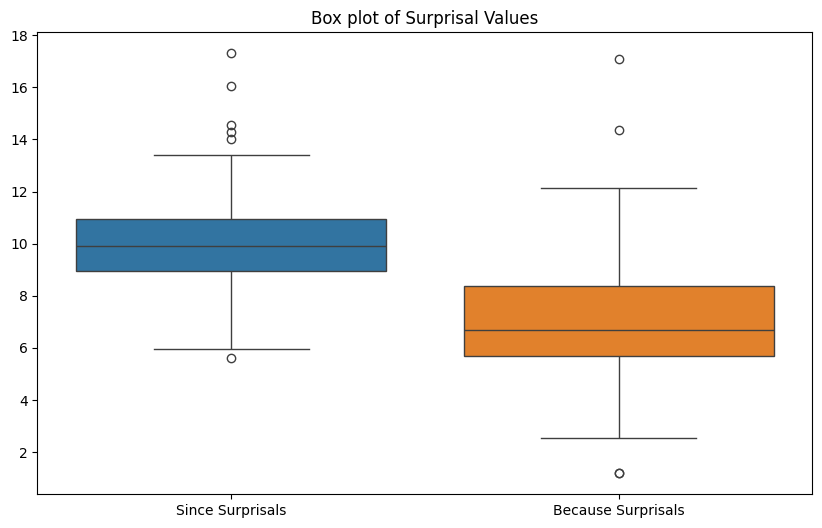

Normality Test p-values: Idioms = 0.0036111949011683464 , Literals = 0.0025725727900862694
Equal Variance Test p-value: 0.04314335951608319


NameError: name 'U1' is not defined

In [ ]:
from tqdm import tqdm
import scipy
e=0
s_surprisals = []
b_surprisals = []
for exp in tqdm(zip(explanation_since, explanation_because)):
  try:
    since_tokens, since_surprisals = preprocess(exp[0])
    because_tokens, because_surprisals = preprocess(exp[1])

    connective_s = get_word_surprisal(since_tokens, since_surprisals)
    connective_b = get_word_surprisal(because_tokens, because_surprisals)

    s_surprisals.append(connective_s)
    b_surprisals.append(connective_b)
  except:
    e+=1
    print('error')
    print(e)

# for exp in tqdm(explanation_because):
#   try:

#     because_last = exp.split()[-1]
#     because_tokens, because_surprisals = preprocess(exp)
#     connective_b = get_word_surprisal(because_tokens, because_surprisals)
#     b_surprisals.append(connective_b)
#   except:
#     e+=1
#     print('error')
#     print(e)


# for ex in tqdm(explanation_since):
#   try:
#     since_last = ex.split()[-1]
#     since_tokens, since_surprisals = preprocess(ex)
#     connective_s = get_word_surprisal(since_tokens, since_surprisals)
#     s_surprisals.append(connective_s)
#   except:
#     e+=1
#     print('error')
#     print(e)

# sorted_keys = sorted(surprisals)
# surprisals = {key: surprisals[key] for key in sorted_keys}

print(len(s_surprisals))
print(len(b_surprisals))
mean_surprisal_s = np.mean(s_surprisals)
mean_surprisal_b = np.mean(b_surprisals)
median_surprisal_s = np.median(s_surprisals)
median_surprisal_b = np.median(b_surprisals)
variance_surprisal_s = np.std(s_surprisals)
variance_surprisal_b = np.std(b_surprisals)

# Print statistics
print(f'mean_surprisal_s: {mean_surprisal_s}')
print(f'mean_surprisal_b: {mean_surprisal_b}')
print(f'median_surprisal_s: {median_surprisal_s}')
print(f'median_surprisal_b: {median_surprisal_b}')
print(f'variance_surprisal_s: {variance_surprisal_s}')
print(f'variance_surprisal_b: {variance_surprisal_b}')

# Create box plots using seaborn or matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(data=[s_surprisals, b_surprisals])
plt.xticks([0, 1], ['Since Surprisals', 'Because Surprisals'])
plt.title('Box plot of Surprisal Values')
plt.show()
plt.savefig('surprisal_boxplot.png')

plt.close()

# Normality test
_, p_value_i = stats.shapiro(s_surprisals)
_, p_value_l = stats.shapiro(b_surprisals)
print("Normality Test p-values: Idioms =", p_value_i, ", Literals =", p_value_l)

# Equal variances test
_, p_value_var = stats.levene(s_surprisals, b_surprisals)
print("Equal Variance Test p-value:", p_value_var)

if p_value_var > 0.05:  # Equal variances
    U1, p_value = mannwhitneyu(s_surprisals, b_surprisals)

else:  # Unequal variances (Welch’s t-test)
    t_stat, p_value = scipy.stats.ttest_ind(s_surprisals, b_surprisals, equal_var=False)

n1 = len(s_surprisals)
n2 = len(b_surprisals)
U2 = n1*n2-U1
print(f'U2{U2}')
u_stat = min(U1, U2)
# Calculate the rank-biserial correlation as effect size
r = 1 - (2 * u_stat) / (n1 * n2)
print("Effect size (rank-biserial correlation):", r)
print("U:", u_stat, "p-value:", p_value)
# Interpretation
if p_value < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference between groups")

In [ ]:
import scipy
if p_value_var > 0.05:  # Equal variances
    U1, p_value = mannwhitneyu(s_surprisals, b_surprisals)

else:  # Unequal variances (Welch’s t-test)
    t_stat, p_value = scipy.stats.ttest_ind(s_surprisals, b_surprisals, equal_var=False)

n1 = len(s_surprisals)
n2 = len(b_surprisals)
U2 = n1*n2-U1
print(f'U2{U2}')
u_stat = min(U1, U2)
# Calculate the rank-biserial correlation as effect size
r = 1 - (2 * u_stat) / (n1 * n2)
print("Effect size (rank-biserial correlation):", r)
print("U:", u_stat, "p-value:", p_value)
# Interpretation
if p_value < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference between groups")

U215485.0
Effect size (rank-biserial correlation): 0.98208
U: 140.0 p-value: 1.6139222347296475e-23
Significant difference between groups


126
126
mean_surprisal_s: 7.715059796927619
mean_surprisal_b: 7.456325599443291
median_surprisal_s: 7.515347330540391
median_surprisal_b: 7.229642180198965
variance_surprisal_s: 1.5080247579045993
variance_surprisal_b: 1.4637354314496378


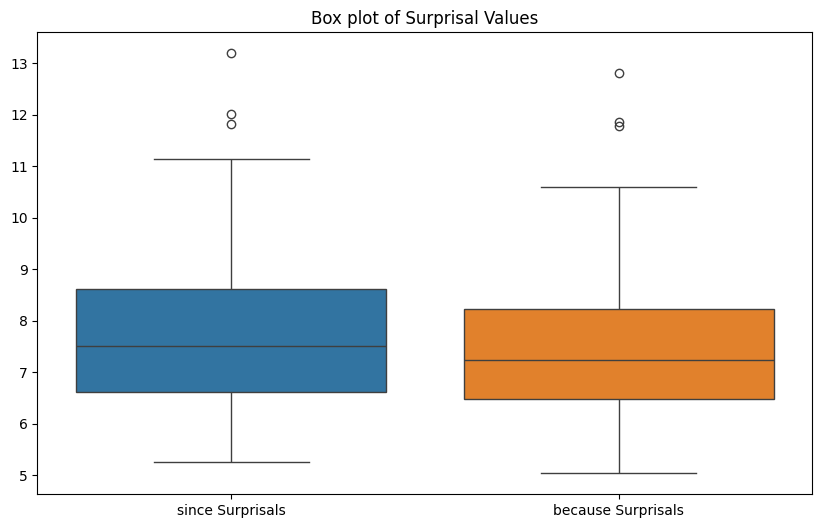

Normality Test p-values: Idioms = 0.00048597302520647645 , Literals = 6.374862277880311e-05
Equal Variance Test p-value: 0.6375092524732231
U27079.0
Effect size (rank-biserial correlation): 0.10821365583270348
U: 7079.0 p-value: 0.13783954790101982
No significant difference between groups


In [ ]:
e=0
s_surprisals = []
b_surprisals = []
for exp in zip(explanation_since, explanation_because):
  try:
    since_last = exp[0].split()[-1]
    because_last = exp[1].split()[-1]
    since_tokens, since_surprisals = preprocess(exp[0])
    because_tokens, because_surprisals = preprocess(exp[1])

    connective_s = get_word_surprisal(since_tokens, since_surprisals)
    connective_b = get_word_surprisal(because_tokens, because_surprisals)

    s_surprisals.append(connective_s)
    b_surprisals.append(connective_b)
  except:
    e+=1
    print('error')
    print(e)

# sorted_keys = sorted(surprisals)
# surprisals = {key: surprisals[key] for key in sorted_keys}

print(len(s_surprisals))
print(len(b_surprisals))
mean_surprisal_s = np.mean(s_surprisals)
mean_surprisal_b = np.mean(b_surprisals)
median_surprisal_s = np.median(s_surprisals)
median_surprisal_b = np.median(b_surprisals)
variance_surprisal_s = np.std(s_surprisals)
variance_surprisal_b = np.std(b_surprisals)

# Print statistics
print(f'mean_surprisal_s: {mean_surprisal_s}')
print(f'mean_surprisal_b: {mean_surprisal_b}')
print(f'median_surprisal_s: {median_surprisal_s}')
print(f'median_surprisal_b: {median_surprisal_b}')
print(f'variance_surprisal_s: {variance_surprisal_s}')
print(f'variance_surprisal_b: {variance_surprisal_b}')

# Create box plots using seaborn or matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(data=[s_surprisals, b_surprisals])
plt.xticks([0, 1], ['since Surprisals', 'because Surprisals'])
plt.title('Box plot of Surprisal Values')
plt.show()
plt.savefig('surprisal_boxplot.png')

plt.close()

# Normality test
_, p_value_i = stats.shapiro(s_surprisals)
_, p_value_l = stats.shapiro(b_surprisals)
print("Normality Test p-values: Idioms =", p_value_i, ", Literals =", p_value_l)

# Equal variances test
_, p_value_var = stats.levene(s_surprisals, b_surprisals)
print("Equal Variance Test p-value:", p_value_var)

if p_value_var > 0.05:  # Equal variances
    U1, p_value = mannwhitneyu(s_surprisals, b_surprisals)

else:  # Unequal variances (Welch’s t-test)
    t_stat, p_value = scipy.stats.ttest_ind(s_surprisals, b_surprisals, equal_var=False)

n1 = len(s_surprisals)
n2 = len(b_surprisals)
U2 = n1*n2-U1
print(f'U2{U2}')
u_stat = min(U1, U2)
# Calculate the rank-biserial correlation as effect size
r = 1 - (2 * u_stat) / (n1 * n2)
print("Effect size (rank-biserial correlation):", r)
print("U:", u_stat, "p-value:", p_value)
# Interpretation
if p_value < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference between groups")

In [ ]:
explanation_since = [x.lower() for x in explanation_since]
explanation_because = [x.lower() for x in explanation_because]

In [ ]:
def cut_off_connectives(explanation, add_token, connective='since'):
  explanation_s = []
  for exp in explanation:
    exp = exp.split()
    since_index = exp.index(connective)
    exp = exp[:since_index+1]
    exp = add_token + ' '.join(exp)
    explanation_s.append(exp)
  return explanation_s

explanation_since = cut_off_connectives(explanation_since,  'actually, ', 'since' )
explanation_because = cut_off_connectives(explanation_since, 'hypothetically,', 'since' )
# explanation_because = cut_off_connectives(explanation_because, 'because')

In [ ]:
explanation_since

['actually, the attention is the main point made in this study , since',
 'actually, it is widely accepted that the corrections of the sea surface and atmospheric effects are essential for remote sensing of sss , since',
 "actually, i think it 'll do fine with a cast , especially since",
 'actually, it ’s neither necessary , possible , nor desirable to erase all gender norms , since',
 'actually, but something in the way he says it ( especially since',
 "actually, that makes more sense , why would monsters be afraid of monsters ? they would n't ... if whatever was outside was like them . which raises the question : what do monsters consider monsters ? humans it seems unlikely , since",
 'actually, (3) it s understandable , since',
 'actually, which are certainly worth the while since',
 'actually, which the remaining population does a commendable job trying to maintain , since',
 "actually, that 's a sign of arrogance , since",
 'actually, they need to be planted 6 inches apart , since

since
since
since
since
since
since
since
since
since
since
since
since
since
since
14
14
mean_surprisal_s: 9.380548875248222
mean_surprisal_b: 12.155020808500515
median_surprisal_s: 8.582266744287622
median_surprisal_b: 11.075443177244495
variance_surprisal_s: 2.3283120612701746
variance_surprisal_b: 3.111156238424221


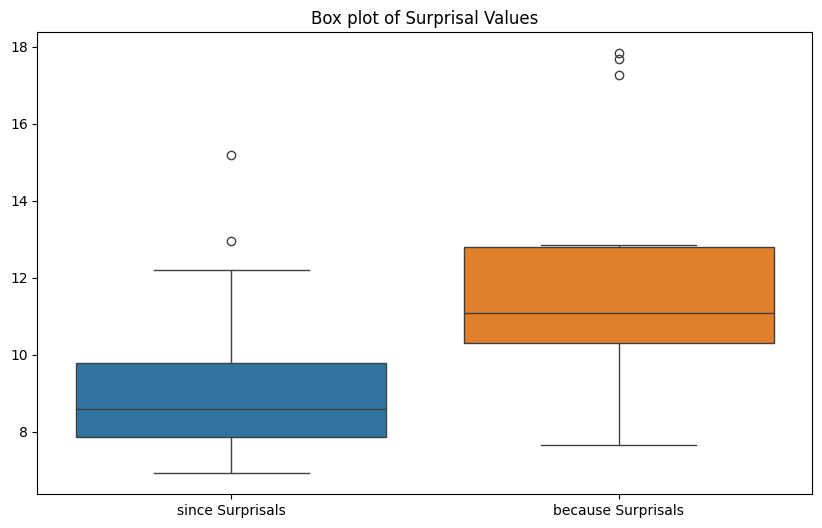

Normality Test p-values: Idioms = 0.011853818781673908 , Literals = 0.03413316234946251
Equal Variance Test p-value: 0.4863868680256952
U2153.0
Effect size (rank-biserial correlation): 0.5612244897959184
U: 43.0 p-value: 0.012274648109661161
Significant difference between groups


In [ ]:
e=0
s_surprisals = []
b_surprisals = []
for exp in zip(explanation_since, explanation_because):
  try:
    since_last = exp[0].split()[-1]
    because_last = exp[1].split()[-1]
    since_tokens, since_surprisals = preprocess(exp[0])
    because_tokens, because_surprisals = preprocess(exp[1])

    connective_s = get_word_surprisal(since_tokens, since_surprisals)
    connective_b = get_word_surprisal(because_tokens, because_surprisals)

    s_surprisals.append(connective_s)
    b_surprisals.append(connective_b)
  except:
    e+=1
    print('error')
    print(e)

# sorted_keys = sorted(surprisals)
# surprisals = {key: surprisals[key] for key in sorted_keys}

print(len(s_surprisals))
print(len(b_surprisals))
mean_surprisal_s = np.mean(s_surprisals)
mean_surprisal_b = np.mean(b_surprisals)
median_surprisal_s = np.median(s_surprisals)
median_surprisal_b = np.median(b_surprisals)
variance_surprisal_s = np.std(s_surprisals)
variance_surprisal_b = np.std(b_surprisals)

# Print statistics
print(f'mean_surprisal_s: {mean_surprisal_s}')
print(f'mean_surprisal_b: {mean_surprisal_b}')
print(f'median_surprisal_s: {median_surprisal_s}')
print(f'median_surprisal_b: {median_surprisal_b}')
print(f'variance_surprisal_s: {variance_surprisal_s}')
print(f'variance_surprisal_b: {variance_surprisal_b}')

# Create box plots using seaborn or matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(data=[s_surprisals, b_surprisals])
plt.xticks([0, 1], ['since Surprisals', 'because Surprisals'])
plt.title('Box plot of Surprisal Values')
plt.show()
plt.savefig('surprisal_boxplot.png')

plt.close()

# Normality test
_, p_value_i = stats.shapiro(s_surprisals)
_, p_value_l = stats.shapiro(b_surprisals)
print("Normality Test p-values: Idioms =", p_value_i, ", Literals =", p_value_l)

# Equal variances test
_, p_value_var = stats.levene(s_surprisals, b_surprisals)
print("Equal Variance Test p-value:", p_value_var)

if p_value_var > 0.05:  # Equal variances
    U1, p_value = mannwhitneyu(s_surprisals, b_surprisals)

else:  # Unequal variances (Welch’s t-test)
    t_stat, p_value = scipy.stats.ttest_ind(s_surprisals, b_surprisals, equal_var=False)

n1 = len(s_surprisals)
n2 = len(b_surprisals)
U2 = n1*n2-U1
print(f'U2{U2}')
u_stat = min(U1, U2)
# Calculate the rank-biserial correlation as effect size
r = 1 - (2 * u_stat) / (n1 * n2)
print("Effect size (rank-biserial correlation):", r)
print("U:", u_stat, "p-value:", p_value)
# Interpretation
if p_value < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference between groups")

['ctually,', 'the', 'attention', 'is', 'the', 'main', 'point', 'made', 'in', 'this', 'study', ',', 'since']
[19.972187042236328, 3.84186053276062, 14.056195259094238, 4.219014644622803, 7.77495002746582, 6.781410217285156, 5.9329986572265625, 11.111777305603027, 3.0811960697174072, 2.9389445781707764, 8.136743545532227, 7.359181880950928, 6.631214618682861]
['ypothetically,actually,', 'the', 'attention', 'is', 'the', 'main', 'point', 'made', 'in', 'this', 'study', ',', 'since']
[49.55934524536133, 4.592968463897705, 13.219470977783203, 4.679431915283203, 7.583697319030762, 6.49678373336792, 6.320009708404541, 11.19339656829834, 2.887209892272949, 3.091776132583618, 8.20032024383545, 7.264631748199463, 6.861074924468994]
['ctually,', 'it', 'is', 'widely', 'accepted', 'that', 'the', 'corrections', 'of', 'the', 'sea', 'surface', 'and', 'atmospheric', 'effects', 'are', 'essential', 'for', 'remote', 'sensing', 'of', 'sss', ',', 'since']
[19.972187042236328, 3.316457509994507, 3.405709028244

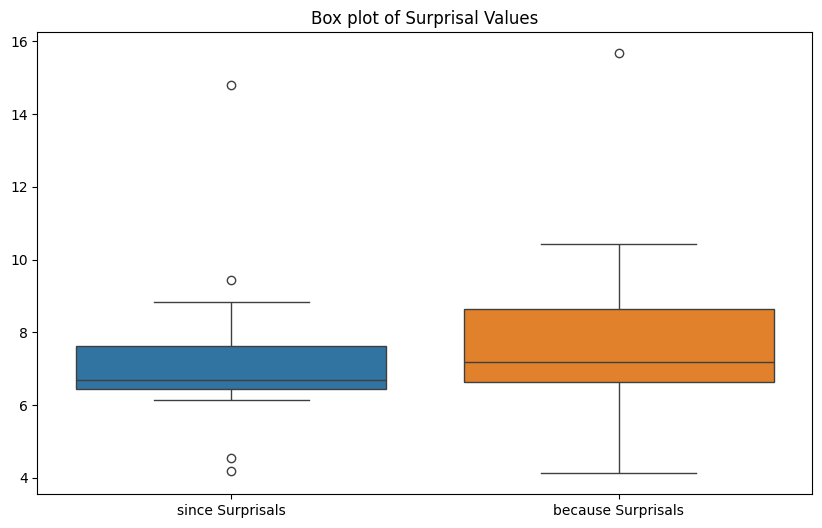

Normality Test p-values: Idioms = 0.00392919359728694 , Literals = 0.03550426661968231
Equal Variance Test p-value: 0.6688395436689119
U2119.0
Effect size (rank-biserial correlation): 0.2142857142857143
U: 77.0 p-value: 0.3462297896371177
No significant difference between groups


In [ ]:
e=0
s_surprisals = []
b_surprisals = []
for exp in zip(explanation_since, explanation_because):
  try:
    since_last = exp[0].split()[-1]
    because_last = exp[1].split()[-1]
    since_tokens, since_surprisals = preprocess(exp[0])
    because_tokens, because_surprisals = preprocess(exp[1])

    s, connective_s = get_word_surprisal(since_tokens, since_surprisals)
    b, connective_b = get_word_surprisal(because_tokens, because_surprisals)

    s_surprisals.append(connective_s)
    b_surprisals.append(connective_b)
  except:
    e+=1
    print('error')
    print(e)

# sorted_keys = sorted(surprisals)
# surprisals = {key: surprisals[key] for key in sorted_keys}

print(len(s_surprisals))
print(len(b_surprisals))
mean_surprisal_s = np.mean(s_surprisals)
mean_surprisal_b = np.mean(b_surprisals)
median_surprisal_s = np.median(s_surprisals)
median_surprisal_b = np.median(b_surprisals)
variance_surprisal_s = np.std(s_surprisals)
variance_surprisal_b = np.std(b_surprisals)

# Print statistics
print(f'mean_surprisal_s: {mean_surprisal_s}')
print(f'mean_surprisal_b: {mean_surprisal_b}')
print(f'median_surprisal_s: {median_surprisal_s}')
print(f'median_surprisal_b: {median_surprisal_b}')
print(f'variance_surprisal_s: {variance_surprisal_s}')
print(f'variance_surprisal_b: {variance_surprisal_b}')

# Create box plots using seaborn or matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(data=[s_surprisals, b_surprisals])
plt.xticks([0, 1], ['since Surprisals', 'because Surprisals'])
plt.title('Box plot of Surprisal Values')
plt.show()
plt.savefig('surprisal_boxplot.png')

plt.close()

# Normality test
_, p_value_i = stats.shapiro(s_surprisals)
_, p_value_l = stats.shapiro(b_surprisals)
print("Normality Test p-values: Idioms =", p_value_i, ", Literals =", p_value_l)

# Equal variances test
_, p_value_var = stats.levene(s_surprisals, b_surprisals)
print("Equal Variance Test p-value:", p_value_var)

if p_value_var > 0.05:  # Equal variances
    U1, p_value = mannwhitneyu(s_surprisals, b_surprisals)

else:  # Unequal variances (Welch’s t-test)
    t_stat, p_value = scipy.stats.ttest_ind(s_surprisals, b_surprisals, equal_var=False)

n1 = len(s_surprisals)
n2 = len(b_surprisals)
U2 = n1*n2-U1
print(f'U2{U2}')
u_stat = min(U1, U2)
# Calculate the rank-biserial correlation as effect size
r = 1 - (2 * u_stat) / (n1 * n2)
print("Effect size (rank-biserial correlation):", r)
print("U:", u_stat, "p-value:", p_value)
# Interpretation
if p_value < 0.05:
    print("Significant difference between groups")
else:
    print("No significant difference between groups")